<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/page_satus_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [0]:
import sys, pickle, os, json, keras, time, re
from sklearn.model_selection import KFold
from keras.datasets import boston_housing
from keras.models import Model,model_from_json
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.datasets import mnist
from keras import models
from keras import layers
import numpy as np
from google.colab import files
from keras.metrics import categorical_accuracy
from scipy.stats import zscore
import random
import pandas as pd
import matplotlib.pyplot as plt
import MeCab
mecab = MeCab.Tagger("-Owakati")

In [0]:
def save_text_tokenizer(tokenizer,file_name):
  # saving
  with open(file_name+".pickle", 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_text_tokenizer(file_name):
  # loading
  with open(file_name+".pickle", 'rb') as handle:
      return pickle.load(handle)

In [107]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/status_filter/"
!ls "/content/gdrive/My Drive/data/status_filter/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
error.csv	page_st.csv  text_token.pickle	used_page_st.csv
new_status.csv	sample.csv   used.csv		weights.best.h5


In [108]:
page_file_name = 'page_st.csv'
target_columns = ['label','text']
dtype ={'label':str,'text':str} 
raw_df = pd.read_csv(base_dir + page_file_name,sep=',',error_bad_lines=False, dtype=dtype,engine='python')
raw_df2 = pd.read_csv(base_dir + 'new_status.csv',sep=',',error_bad_lines=False, dtype=dtype,engine='python')
raw_df = pd.concat([raw_df,raw_df2],axis=0)
raw_df = raw_df[~raw_df.duplicated()]
print('raw_df',raw_df.shape)
print(raw_df.columns)
print(raw_df['label'].value_counts())
raw_df.to_csv(base_dir+'used.csv',index=False)

raw_df (2233, 3)
Index(['label', 'url', 'text'], dtype='object')
no        1414
stock      545
list       134
top         87
login       24
nan         13
except      11
block        5
Name: label, dtype: int64


In [0]:
def change_label(label):
  if label != 'stock' :label = 'no'
  return label

raw_df['label'] = raw_df['label'].apply(lambda x : change_label(x))

In [110]:
raw_df = raw_df.dropna()
raw_df = raw_df.sample(frac=1)
print(raw_df["label"].value_counts())
print('raw_df',raw_df.shape)
print(raw_df.columns)


no       1688
stock     545
Name: label, dtype: int64
raw_df (2233, 3)
Index(['label', 'url', 'text'], dtype='object')


In [111]:
text = 'sorry we can t this product page 　　re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 ました 売り 切れ ページ 見つかり ません この 製品 もう 入手 できません'
def prepro(text:str)->list:
  line = ""
  text = mecab.parse(str(text)).replace("↵"," ")
  text = re.sub('{.*}','',text)
  words = text.lower().split(' ')
  for word in words:
    regex = "^(此|宝|贝|已|下架|품절|또는|판매가|중지된|상품입니다|access|trova|negozio|unfortunate|denied|esaurito|online|only|sorry|we|can|this|product|page|re|sold|404|whoops|ARTICOLO NON DISPONIBILE|our|bad|it|gone|out|of|low|stock|select|no|one|size|please|choose|cat|add|選択|カート|追加|切れ|在庫|なし|し|完売|ました|売り|切れ|ページ|見つかり|ませ|ん|この|製品|もう|入手|でき|ない|ci|scusiamo|per|inconveniente|back|to|our|favs|product|page|item|requested|is|was|not|found|no|longer|server|error|available|購入|いただけ|ません|ARTICLE|EN|LIGNE|so|articolo|non|disponibile|很抱歉|您|查看|的|页面|找不到|了)";
    regex = regex.lower()
    match = re.search(regex, word)
    if match:
      line += word+" "
#   print('line',len(line.split()))
  return line
prepro(text)


'sorry we can this product page re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 売り 切れ ページ 見つかり ませ ん この 製品 もう 入手 でき ませ ん '

In [120]:
raw_df['edit_text'] = raw_df['text'].apply(lambda x : prepro(x))
regex = "^(sorry.? (we can.t|this (product|page)))|^(sorry we.re sold out)|^(404|whoops, our bad...|it.s gone|out of stock|sold out|在庫切れ|在庫なし|完売しました|売り切れ|ページが見つかりません.*|この製品はもう入手できない.|ci scusiamo per l'inconveniente.|sorry!|back to our favs)$|(((product|page|item|requested) (is |was )?)(not found|no longer|sold out|out of stock|not available))|(re (sorry|sold out)|(ご購入いただけません)|(404 error))|^(sold out\\s*){3,}|ARTICLE.*EN LIGNE|^so sorry.*|404 page not|Don.t Cry|.*is out of stock.|articolo non disponibile";
p = re.compile(regex)
raw_df['flag'] = raw_df['text'].apply(lambda x : 0 if p.match(x) == None else 1)
raw_df['edit_text'] = raw_df['edit_text'].fillna("")

token = keras.preprocessing.text.Tokenizer(num_words=250)
token.fit_on_texts(raw_df['edit_text'].values)
save_text_tokenizer(token,base_dir + 'text_token')
X = token.texts_to_matrix(raw_df['edit_text'].values)
flag = np.array(raw_df['flag'])
flag = flag.reshape(len(flag),1)
print('flag',flag.shape,'X',X.shape)
X = np.concatenate((flag,X),axis=1)

# X = flag
# text_len = len(X[0])
# print(f'text_len:{text_len} samples:{len(X)}')
print('word_count',len(token.word_counts))
print(token.word_counts)
print(token.word_index)
X = np.array(X)
print('X',X.shape)

flag (2233, 1) X (2233, 250)
word_count 1438
OrderedDict([('404', 348), ('not', 1974), ('found', 695), ('we', 1485), ('one', 427), ('this', 2053), ('page', 1581), ('to', 7716), ('our', 2893), ('website', 478), ('performance', 47), ('social', 178), ('personalized', 114), ('of', 3697), ('personal', 250), ('requested', 398), ('was', 429), ('please', 818), ('is', 1567), ('outdated', 77), ('can', 572), ('back', 784), ('top', 863), ('products', 364), ('enquiries', 43), ('returns', 1652), ('en', 355), ('sold', 294), ('out', 976), ('size', 2056), ('add', 856), ('return', 538), ('refunds', 96), ('receive', 427), ('regarding', 12), ('offers', 346), ('canada', 274), ('islands', 1540), ('republic', 881), ('city', 227), ('islamic', 33), ('israel', 125), ('italy', 424), ('norfolk', 97), ('island', 453), ('north', 122), ('northern', 85), ('norway', 146), ('peru', 135), ('reunion', 68), ('tome', 55), ('solomon', 128), ('somalia', 116), ('south', 424), ('togo', 128), ('tokelau', 76), ('tonga', 129), ('

In [0]:
index2word =  {i+1:key for i, key in enumerate(token.word_index)}
# index2word

In [0]:
# label_token = keras.preprocessing.text.Tokenizer()
# label_token.fit_on_texts(raw_df['label'].values)
# y = label_token.texts_to_matrix(raw_df['label'].values)
# label_len = len(label_token.word_counts) + 1

y = to_categorical(raw_df['label'].apply(lambda x : 1 if x == 'stock' else 0))
# print('word_index',label_token.word_index)
# print('label_len',label_len)
# print('y shape',y.shape)

In [0]:
raw_df['true'] = raw_df['label'].apply(lambda x : 1 if x == 'stock' else 0)

In [124]:

def get_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Embedding(1000, 64, input_length= len(X[0])))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(256,activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(512,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(256,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(2,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer =keras.optimizers.RMSprop(),metrics=['categorical_accuracy'])
  return model

get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 251, 64)           64000     
_________________________________________________________________
flatten_34 (Flatten)         (None, 16064)             0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 16064)             0         
_________________________________________________________________
dense_77 (Dense)             (None, 256)               4112640   
_________________________________________________________________
dropout_78 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 2)                 514       
Total params: 4,177,154
Trainable params: 4,177,154
Non-trainable params: 0
_________________________________________________________________


In [125]:

EPOCHS = 30
BATCH_SIZE = 32

# stop when score is not improve
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=20)

# save best score
filepath = base_dir+"weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')

# reduce 
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)
callbacks_list = [checkpoint,early_stopping,reduce]

scores = []
historys = []
kf = KFold(n_splits=4, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
  model = get_model()
  history = model.fit(X[train_index], y[train_index], validation_split=0.2,verbose=0,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=callbacks_list)
  historys.append(history)
  score = model.evaluate(X[test_index],y[test_index])
  print(score)
  scores.append(score)

load_model = keras.models.load_model(filepath)
score = load_model.evaluate(X[test_index],y[test_index])
print('Test best loss:', score[0])
print('Test best accuracy:', score[1])

559/559 [==============================] - 0s 86us/step
[0.34355678655913563, 0.9069767442926738]
558/558 [==============================] - 0s 83us/step
[0.3707081670722654, 0.9175627233734268]
558/558 [==============================] - 0s 85us/step
[0.3567018577675452, 0.9157706093189965]
558/558 [==============================] - 0s 84us/step
[0.4606117171946392, 0.9103942654466116]
558/558 [==============================] - 1s 2ms/step
Test best loss: 0.4309182208712383
Test best accuracy: 0.9032258066652497


In [135]:
print("KFlod")
print("Sample",len(X))
print("Score",pd.DataFrame(scores).mean()[1]*100)
print("Std",pd.DataFrame(scores).std()[1]*100)


KFlod
Sample 2233
Score 91.26760856079271
Std 0.48697878230958264


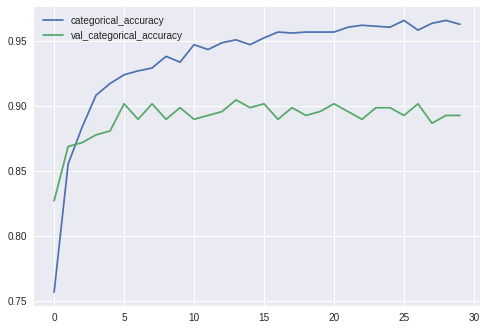

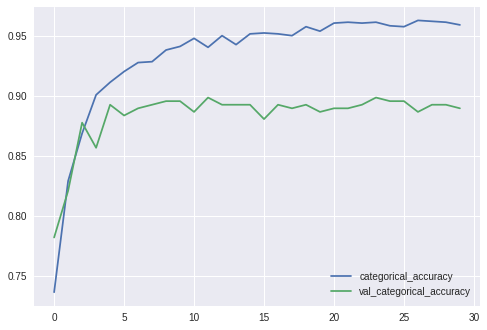

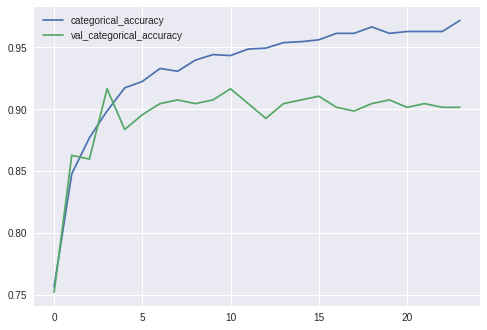

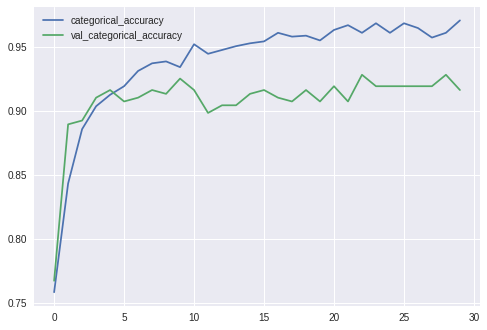

In [127]:
for i in range(len(historys)):
  df = pd.DataFrame(historys[i].history)
#   df.filter(regex=('loss*')).plot()
  df.filter(regex=('accuracy$')).plot()
  
plt.show()
  

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


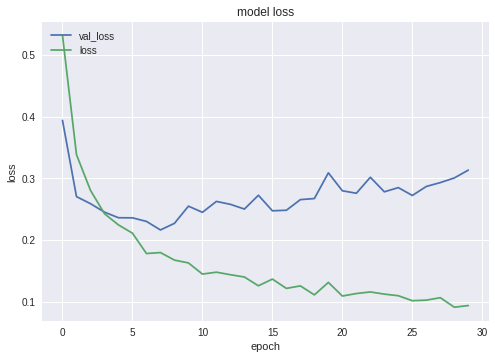

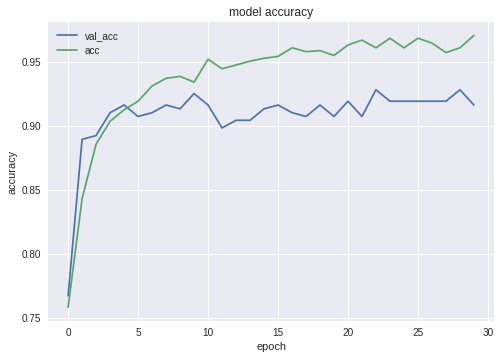

In [128]:

import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()

In [129]:
# print('word_index',label_token.word_index)
# raw_df['true'] = None
raw_df['pred'] = None
results = load_model.predict(X[test_index])
for i in range(len(results)):
  raw_df.loc[i,'pred'] = np.argmax(results[i])
#   raw_df.loc[i,'true'] = np.argmax(y[test_index])
#   if pred == ans:continue
#   print('x:',pred ,' O:' ,ans)
#   raw_df.loc[i,'pred']  = pred
#   print(raw_df[i:i+1]['edit_text'])
result_df = raw_df.query("pred == 0 or pred == 1")
result_df
# raw_df[ls].to_csv(base_dir+'error.csv',index=False)

,label,url,text,edit_text,flag,true,pred
463,stock,https://www.julian-fashion.com/en-US/product/6...,WOMEN↵MEN↵KIDS↵OUTLET↵SHIP TO: IT - € - ENG↵↵↵...,outlet to it eng size return size select size ...,0,1,0
442,no,https://www.lesnereides.com/asia/283-charms-br...,NEWSLETTER SUBSCRIPTION CONTACT\n0\nEN Our sto...,en our of is of of nowadays touch of to read o...,0,0,0
461,stock,https://www.julian-fashion.com/en-US/product/5...,WOMEN↵MEN↵KIDS↵OUTLET↵SHIP TO: IT - € - ENG↵↵↵...,outlet to it eng red size to size return size ...,0,1,1
249,stock,https://www.gldn.com/earrings/heart-wire-stud,Order by Feb. 4 to receive by Valentine's Day ...,to receive production return our perfect of th...,0,1,0
476,stock,http://scenerity.co.kr/product/detail.html?pro...,전체상품목록 바로가기↵본문 바로가기↵LOG-IN JOIN MYPAGE↵NOTICE ...,notice review outerwear tops size size total a...,0,1,1
496,no,https://us.asos.com/river-island/river-island-...,Skip to main content\nMarketplace\nHelp & FAQs...,to items outlet island red island red product ...,0,0,0
230,no,https://us.fashionbunker.com/live-and-learn-pl...,JOIN SIGN IN\n1\n0\nUSD\nNEW\nDRESSES\nTOPS\nB...,tops page not found we sorry page cannot found...,0,0,0
390,no,https://www.lackofcolor.com.au/products/the-elrod,Skip to content\nshop\ncollections\nshop insta...,to 404 page not found page requested not our r...,0,0,0
247,no,https://www.saksoff5th.com/furla-miky-pebbled-...,.st0{fill:none}new-arrivals.st0{fill:none;stro...,welcome to accessories to now to out we re to ...,0,0,0
259,no,https://www.littleblackdress.co.uk/brands/lips...,This website uses cookies to enhance your expe...,this website to enhance our website of our rea...,0,0,0


In [0]:
error_df = result_df[['label','true','pred','edit_text']].query("true != pred")
error_df[['label','true','pred','edit_text']].to_csv(base_dir+'error.csv',index=False)

In [131]:
len(error_df)

514